# The first prototype of the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout.  

Authors: Tobey Carman and Elchin Jafarov

## Working with the docker 
Assuming that docker was successfully installed, navigate to your local dvmdostem folder:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou
import os
import subprocess
from contextlib import contextmanager


In [11]:
@contextmanager
def log_wrapper(message,tag=''):
    print('[SA:{}] {}'.format(tag, message))
    try:
        yield
    finally:
        print()

class Sensitivity:
    """Sensitivity analysis class."""

    def __init__(self):
        self.PARAM = 'cmax'
        self.PFTNUM = 1 #plant functional type
        self.CMTNUM = 4 #community type

        # row and columns location of the point/site
        self.PXx = 0
        self.PXy = 0

        # output variables to use...
        self.output_vars = ('GPP','VEGC','VEGN')

        # the variable corresponds to the path where we will run the analysis
        self.work_dir = '/data/workflows/sensitivity_analysis'
        self.input_cat = '/data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/'
        # the sample distribution range (in this case vcmax in [vcmax_min,vcmax_max])
        self.samples = np.linspace(start=100, stop=700, num=20)


    def setup(self):
        '''Sequence of steps necessary to commence sensitvity analysis.'''

        os.chdir('/work/scripts')

        with log_wrapper('Cleaning up...',tag='setup') as lw:
            if os.path.exists(self.work_dir):
                os.system('rm -r {}'.format(self.work_dir))

        m = 'Copy params, config files into the new_folder, adjust paths in config...'
        with log_wrapper(m,tag='setup') as lw:
            program = '/work/scripts/setup_working_directory.py'
            opt_str = '--input-data-path {} {}'.format(self.input_cat, self.work_dir)
            cmdline = program + ' ' + opt_str
            print('Running setup:', cmdline)
            comp_proc = subprocess.run(cmdline, shell=True, check=True, capture_output=True) 
            #print()


        print('---> Apply the mask...')
        program = '/work/scripts/runmask-util.py'
        options = '--reset --yx {} {} {}/run-mask.nc'.format(self.PXy, self.PXx, self.work_dir)
        cmdline = program + ' ' + options
        print("Running:", cmdline)
        comp_proc = subprocess.run(cmdline, shell=True, check=True, capture_output=True)
        print()
        
        print('---> Enable output variables in outspec.csv file...')
        for v in self.output_vars:
            program = '/work/scripts/outspec_utils.py'
            options = '{}/config/output_spec.csv --on {} m p'.format(self.work_dir, v)
            cmdline = program + ' ' + options
            print("Running:", cmdline)
            comp_proc = subprocess.run(cmdline, shell=True, capture_output=True, check=True)
        print()

        print('---> Turn on the CMT output only yearly resolution...')
        program = '/work/scripts/outspec_utils.py'
        options = '{}/config/output_spec.csv --on CMTNUM y'.format(self.work_dir)
        cmdline = program + ' ' + options
        print("Running:", cmdline)
        comp_proc = subprocess.run(cmdline, shell=True, check=True, capture_output=True)
        print()
        
        print('---> Modify config file to enable equlibrium outputs...')
        CONFIG_FILE = self.work_dir + '/config/config.js'
        # Read the existing data into memory
        with open(CONFIG_FILE, 'r') as f:
            config = json.load(f)
            
        # Modify value...
        config['IO']['output_nc_eq'] = 1

        # Write it back..
        print('CONFIG_FILE:',CONFIG_FILE,'was modified!')
        with open(CONFIG_FILE, 'w') as f:
            json.dump(config, f, indent=2)
        print()
            
        # Backup default params. The defaults will be static, and 
        # in each run, the parameters in the parameters/ directory
        # will be modified...
        print('---> Backup default params...')
        !cp -r {self.work_dir}/parameters {self.work_dir}/default_parameters
        print()

        # Make an empty file for storing our sensitivity data
        # and put the header in the file.
        print('---> Create empty file for accumulating sensitivity results...')
        with open('{}/sensitivity.csv'.format(self.work_dir), 'w') as f:
            f.write('{:},{:},{:}\n'.format('pvalue','output_gpp','output_vegc'))
        print()

    def update_param(self,new_value):
        # reading dvmdostem param file and puts it in the json format
        data = !param_util.py --dump-block-to-json {self.work_dir}/default_parameters/cmt_calparbgc.txt {self.CMTNUM}
        jdata = json.loads(data[0])

        pft = 'pft{}'.format(self.PFTNUM)
        jdata[pft][self.PARAM] = new_value

        with open("tmp_json.json", 'w') as f:
            json.dump(jdata, f)

        new_data = !param_util.py --fmt-block-from-json tmp_json.json {self.work_dir}/default_parameters/cmt_calparbgc.txt

        with open('{:}/parameters/cmt_calparbgc.txt'.format(self.work_dir), 'w') as f:
            # make sure to add newlines!
            f.write('\n'.join(new_data))
    
    def collect_outputs(self):

        # Next step will be trying to loop over the self.output_vars...
        # not sure how to handle sum over fluxes for pool vars??
        # need more complicated data structure for self.output_vars that 
        # can describe what the vars are??
        ds = nc.Dataset('{}/output/VEGC_monthly_eq.nc'.format(self.work_dir))
        vegc = ds.variables['VEGC'][:]
        yr_vegc = ou.average_monthly_pool_to_yearly(vegc)
        out_vegc = yr_vegc[-1:,self.PFTNUM, self.PXy,self.PXx]

        # Get the model output
        ds = nc.Dataset('{}/output/GPP_monthly_eq.nc'.format(self.work_dir))
        gpp = ds.variables['GPP'][:]
        yr_gpp = ou.sum_monthly_flux_to_yearly(gpp)
        # grab the last time step
        out_gpp = yr_gpp[-1:,self.PFTNUM,self.PXy,self.PXx]

        # Get the parameter value for the run
        paramdata = !param_util.py --dump-block-to-json {self.work_dir}/parameters/cmt_calparbgc.txt {self.CMTNUM}
        jparamdata = json.loads(paramdata[0])
        pft = 'pft{}'.format(self.PFTNUM)
        run_param_value = jparamdata[pft][self.PARAM]

        #need to modify if we want to save timeseries output
        # Need to syncronize this with setting up header!!
        with open('{}/sensitivity.csv'.format(self.work_dir), 'a') as f:
            f.write('{:},{:},{:}\n'.format(run_param_value, out_gpp[0], out_vegc[0]))

    def run_model(self):
        m = "Running model..."
        with log_wrapper(m, tag='run') as lw:
            program = '/work/dvmdostem'
            ctrl_file = os.path.join(self.work_dir, 'config','config.js')
            opt_str = '-p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt {} --ctrl-file {}'.format(self.CMTNUM, ctrl_file)
            command_line = program + ' ' + opt_str
            print("Running command: ", command_line)
            completed_process = subprocess.run(
                command_line,        # The program + options 
                shell=True,          # must be used if passing options as str and not list
                check=True,          # raise CalledProcessError on failure
                capture_output=True, # collect stdout and stderr
                cwd=self.work_dir)   # control context



In [14]:
x = Sensitivity()
x.setup()

[SA:setup] Cleaning up...

[SA:setup] Copy params, config files into the new_folder, adjust paths in config...
Running setup: /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_analysis

---> Apply the mask...
Running: /work/scripts/runmask-util.py --reset --yx 0 0 /data/workflows/sensitivity_analysis/run-mask.nc

---> Enable output variables in outspec.csv file...
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on GPP m p
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on VEGC m p
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on VEGN m p

---> Turn on the CMT output only yearly resolution...
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on CMTNUM y

---> Modify

In [15]:
x.run_model()
x.collect_outputs()

[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js



In [17]:
for i in x.samples:
    print("adjust_param({:}) --> run_model() --> collect_outputs()".format(i))
    x.update_param(i)
    x.run_model()
    x.collect_outputs()

adjust_param(100.0) --> run_model() --> collect_outputs()
[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js

adjust_param(131.57894736842104) --> run_model() --> collect_outputs()
[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js

adjust_param(163.1578947368421) --> run_model() --> collect_outputs()
[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js

adjust_param(194.73684210526315) --> run_model() --> collect_outputs()
[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js

adjust_param(226.31578947368422) --> r

In [18]:
df = pd.read_csv('{:}/sensitivity.csv'.format(x.work_dir))
df.head(4)

,pvalue,output_gpp,output_vegc
0,340.000000,164.255175,443.667206
1,100.000000,43.289263,290.937872
2,131.578947,58.895300,305.839118
3,163.157895,73.859708,321.736593


<AxesSubplot:xlabel='pvalue'>

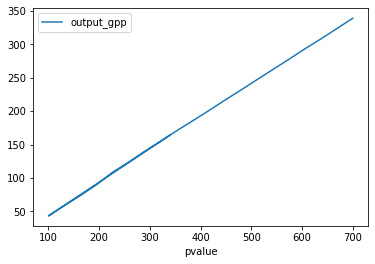

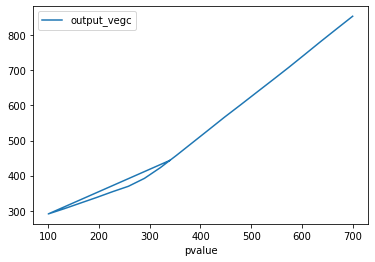

In [26]:
df.plot('pvalue','output_gpp')
df.plot('pvalue','output_vegc')

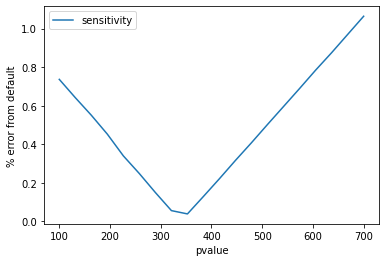

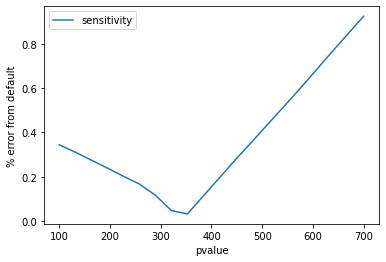

In [27]:
gpp_sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=abs(df.output_gpp[0] - df.output_gpp[1:])/abs(df.output_gpp[0])))
vegc_sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=abs(df.output_vegc[0] - df.output_vegc[1:])/abs(df.output_vegc[0])))

axes = gpp_sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')
axes = vegc_sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')